In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py

lmap = lambda func, *iterable: list(map(func, *iterable))

c:\Users\Michi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Please download the .h5 dataset. 

Note: v0.1.0 refered to "Visual Category" as "Datatype".

In [17]:
temp = pd.read_hdf("F:/dataset.h5/dataset.h5", "meta")

layer_depth             filter_ids  \
model_id conv_depth conv_depth_norm                                       
0        0          0.000000                   1                   0:95   
         1          0.019608                   3                 96:127   
         4          0.078431                  10                128:223   
         7          0.137255                  16                224:367   
         10         0.196078                  23                368:511   
...                                          ...                    ...   
667      110        0.894309                 374  1463056356:1463158755   
         75         0.609756                 261  1463158756:1463568355   
         119        0.967480                 403  1463568356:1463977955   
         77         0.626016                 267  1463977956:1464387555   
         121        0.983740                 409  1464387556:1464797155   

                                                                          model  \
model_id conv_depth conv_depth_norm                                               
0        0          0.000000         agripredict_disease_classification_prop_11   
         1          0.019608         agripredict_disease_classification_prop_11   
         4          0.078431         agripredict_disease_classification_prop_11   
         7          0.137255         agripredict_disease_classification_prop_11   
         10         0.196078         agripredict_disease_classification_prop_11   
...                                                                         ...   
667      110        0.894309                            yolov5x_v40_coco2017_12   
         75         0.609756                            yolov5x_v40_coco2017_12   
         119        0.967480                            yolov5x_v40_coco2017_12   
         77         0.626016                            yolov5x_v40_coco2017_12   
         121        0.983740                            yolov5x_v40_coco2017_12   

                                                                                  path  \
model_id conv_depth conv_depth_norm                                                      
0        0          0.000000         /data/onnx_zoo/agripredict_disease_classificat...   
         1          0.019608         /data/onnx_zoo/agripredict_disease_classificat...   
         4          0.078431         /data/onnx_zoo/agripredict_disease_classificat...   
         7          0.137255         /data/onnx_zoo/agripredict_disease_classificat...   
         10         0.196078         /data/onnx_zoo/agripredict_disease_classificat...   
...                                                                                ...   
667      110        0.894309               /data/onnx_zoo/yolov5x_v40_coco2017_12.onnx   
         75         0.609756               /data/onnx_zoo/yolov5x_v40_coco2017_12.onnx   
         119        0.967480               /data/onnx_zoo/yolov5x_v40_coco2017_12.onnx   
         77         0.626016               /data/onnx_zoo/yolov5x_v40_coco2017_12.onnx   
         121        0.983740               /data/onnx_zoo/yolov5x_v40_coco2017_12.onnx   

                                          producer  op_set  Transpose   Conv  \
model_id conv_depth conv_depth_norm                                            
0        0          0.000000         tf2onnx 1.9.0      11        2.0   52.0   
         1          0.019608         tf2onnx 1.9.0      11        2.0   52.0   
         4          0.078431         tf2onnx 1.9.0      11        2.0   52.0   
         7          0.137255         tf2onnx 1.9.0      11        2.0   52.0   
         10         0.196078         tf2onnx 1.9.0      11        2.0   52.0   
...                                            ...     ...        ...    ...   
667      110        0.894309           pytorch 1.7      12        3.0  134.0   
         75         0.609756           pytorch 1.7      12        3.0  134.0   
         1

## Load data

In [20]:
dataset_path = "F:/dataset.h5/dataset.h5"

In [21]:
with h5py.File(dataset_path, "r") as f:
    dX = f["filters"][...].reshape(-1, 9).astype(np.float16)

dX

MemoryError: Unable to allocate 17.6 GiB for an array with shape (524563289, 9) and data type float32

In [8]:
df_meta = pd.read_hdf("F:/dataset.h5/dataset.h5", "meta")
# df_meta = np.array_split(df_meta, 8)[0]
df_meta["filter_ids"] = df_meta["filter_ids"].apply(lambda s: list(np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1]))))
df_meta["Task"] = df_meta["Task"].apply(lambda s: "Segmentation" if "Segmentation" in s else s)  # v1.0.0 had unreliable labeling of Segmentation models, so we clean it

## Scale the filters by absolute peak weight

In [9]:
def scale(X):
    den = np.abs(X).max(axis=1)
    den = np.where(den == 0, 1, den)[:, None]
    return X / den

dX_scaled = scale(dX)

## Perform PCA transformation

In [11]:
pca = PCA(n_components=9)
dX_n = pca.fit_transform(dX_scaled)

MemoryError: Unable to allocate 35.2 GiB for an array with shape (524563289, 9) and data type float64

In [ ]:
pca.mean_

array([-0.03147636, -0.0475443 , -0.03189288, -0.04796251, -0.07492768,
       -0.04708379, -0.03181933, -0.04694377, -0.03238003])

In [ ]:
dX_n_range = (dX_n.min(), dX_n.max())

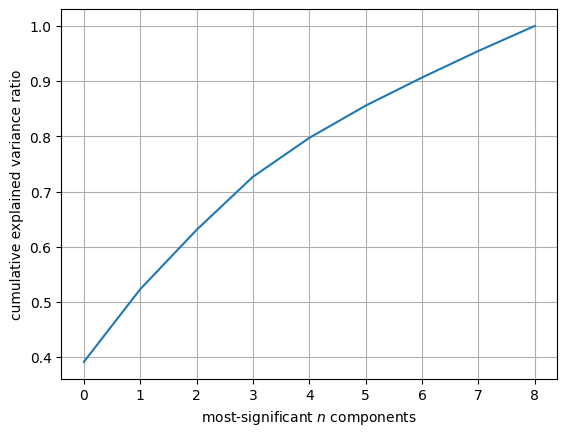

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel("cumulative explained variance ratio")
plt.xlabel("most-significant $n$ components")
plt.grid()
plt.show()

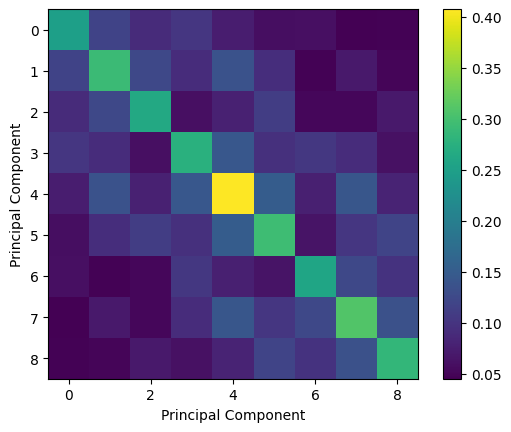

In [ ]:
plt.imshow(pca.get_covariance())
plt.xlabel("Principal Component")
plt.ylabel("Principal Component")
plt.colorbar()
plt.show()

## Compute *subset* eigenimages and explained variance ratio

To compute the eigenimages of different splits, just select the filter_ids from the meta table and compute a PCA on the subset.
As an example we select all filters with datatype "fractals" but you can change this to any selection you'd like. Note: in v0.1.0 "fractals" was called "formula".

In [ ]:
filter_mask = np.hstack(df_meta[df_meta["Visual Category"] == "fractals"].filter_ids)
subset_pca = PCA(n_components=9)
subset_pca.fit(dX_scaled[filter_mask])

ValueError: need at least one array to concatenate

AttributeError: 'PCA' object has no attribute 'components_'

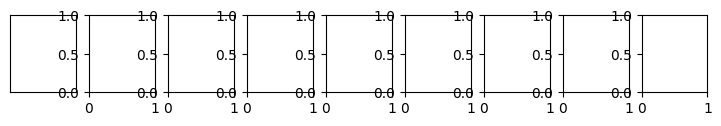

In [ ]:
fig, axes = plt.subplots(1, 9, figsize=(9, 1))
for i, ax in enumerate(axes):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    im = ax.imshow(subset_pca.components_[i].reshape(3, 3), vmin=-1, vmax=1, cmap="seismic")
    ax.set_title(f"$v_{i}$", fontweight='bold', fontsize=18)
    ax.set_xlabel(f"{subset_pca.explained_variance_ratio_[i]:.2f}", fontsize=18)
    
cb_ax = fig.add_axes([0.83, 0.15, 0.1, 0.7])
cb_ax.axis("off")
fig.colorbar(im, ax=cb_ax)
plt.show()

In [ ]:
plt.plot(np.cumsum(subset_pca.explained_variance_ratio_))
plt.ylabel("cumulative explained variance ratio")
plt.xlabel("most-significant $n$ components")
plt.grid()
plt.show()

NameError: name 'subset_pca' is not defined

## Generate ridge plots

In [ ]:
def ridge_plot(X, xrange, shape, row_labels=None, col_labels=None, figsize=(40, 10)):
    gs = grid_spec.GridSpec(*shape)
    fig = plt.figure(figsize=figsize)

    ax_objs = []
    for i in tqdm(range(shape[0])):
        for j in range(shape[1]):

            data = X[i][j]            
            dx, dy = FFTKDE(kernel="gaussian", bw='silverman').fit(data).evaluate()

            color = f"C{i%10}"
            
            # creating new axes object
            ax_objs.append(fig.add_subplot(gs[i:i+1, j:j+1]))

            # plotting the distribution
            ax_objs[-1].plot(dx, dy, color="#f0f0f0", lw=1)
            ax_objs[-1].fill_between(dx, dy, alpha=.7, color=color)

            # setting uniform x and y lims
            ax_objs[-1].set_xlim(*xrange)

            # make background transparent
            ax_objs[-1].patch.set_alpha(0)

            # remove borders, axis ticks, and labels
            ax_objs[-1].set_yticklabels([])
            ax_objs[-1].set_yticks([])
            ax_objs[-1].set_ylim([0, None])

            for s in ["top", "right", "left", "bottom"]:
                ax_objs[-1].spines[s].set_visible(False)
            
            if i == shape[0] - 1:
                ax_objs[-1].tick_params(direction="inout")
                ax_objs[-1].spines["bottom"].set_visible(True)
                
                if col_labels is not None:
                    ax_objs[-1].set_xlabel(col_labels[j])
            else:
                ax_objs[-1].set_xticks([])
                ax_objs[-1].set_xticklabels([])

            if j == 0 and row_labels is not None:
                ax_objs[-1].text(xrange[0] - 0.1, 0, row_labels[i], ha="right", wrap=True, color=color)

    gs.update(hspace=-0.5)

In [ ]:
datatype_distributions = df_meta.groupby("Visual Category").filter_ids.apply(lambda x: dX_n[np.hstack(x)].T)

figsize=(18, 1 + 0.5 * len(datatype_distributions))
ridge_plot(datatype_distributions.values, xrange=dX_n_range, 
           shape=(len(datatype_distributions), 9), 
           row_labels=datatype_distributions.index, 
           col_labels=lmap(lambda i: f"$c_{i}$", range(9)), 
           figsize=figsize)
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()

IndexError: index 1051392874 is out of bounds for axis 0 with size 183099645

## Generate KL-matrices and boxplots

In [ ]:
def kl_sym(p, q):
    return scipy.stats.entropy(p, q) + scipy.stats.entropy(q, p)

def nd_kl_sym(p, q, weights=None):
    if type(p) is not list and len(p.shape) == 1:
        return kl_sym(p, q)
    else:
        return np.sum(lmap(lambda i: weights[i] * kl_sym(p[i], q[i]), range(len(p))))

def get_kl_matrix(data, bins, x_range, weights=None):
    d = len(data)
    kl_matrix = np.zeros((d, d))
    lookup = dict()
    for p, q in tqdm(itertools.product(range(d), repeat=2), total=d**2):
        if p not in lookup:
            lookup[p] = get_nd_discrete_probability_distribution(data[p], x_range, bins)
        if q not in lookup:
            lookup[q] = get_nd_discrete_probability_distribution(data[q], x_range, bins)
                
        kl_matrix[p, q] = nd_kl_sym(lookup[p], lookup[q], weights=weights)
    return kl_matrix

def get_discrete_probability_distribution(X, _range, bins):
    v, _ = np.histogram(X, range=_range, bins=bins, density=True)  # density will not sum to 1 but help to not underflow eps during normalization
    v = v.astype(np.double) 
    v[v == 0] = np.finfo(np.float32).eps
    v = v / np.sum(v)
    return v

def get_nd_discrete_probability_distribution(X, _range, bins):
    if type(X) is not list and len(X.shape) == 1:
        return get_discrete_probability_distribution(X, _range, bins)
    else:
        dims = list()
        for x in X:
            v = get_discrete_probability_distribution(x, _range, bins)
            dims.append(v)
        return np.vstack(dims)

def kl_plot(s, figsize=(10, 10), ax=None, sort=True, **kwargs):
    created = False
    if ax is None:
        created = True
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    img = get_kl_matrix(s.values, **kwargs)
    labels = s.index
    if sort:
        sort_index = np.argsort(np.mean(img, axis=0))
        img = img[sort_index][:, sort_index]
        labels = labels[sort_index]
    
    cim = ax.imshow(img, cmap=cc.cm["fire"])
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(range(len(s)))
    ax.set_yticklabels(labels, rotation=0)
    
    if created:
        plt.colorbar(cim)
    
    return ax, img

In [ ]:
task_distributions = df_meta.groupby("Task").filter_ids.apply(lambda x: dX_n[np.hstack(x)].T)
axes, kl_mat = kl_plot(task_distributions, x_range=dX_n_range, bins=70, weights=pca.explained_variance_ratio_, sort=True)
del task_distributions
plt.show()

In [ ]:
datatype_distributions = df_meta.groupby("Visual Category").filter_ids.apply(lambda x: dX_n[np.hstack(x)].T)
axes, kl_mat = kl_plot(datatype_distributions, x_range=dX_n_range, bins=70, weights=pca.explained_variance_ratio_, sort=True)
del datatype_distributions
plt.show()

In [ ]:
depth_inv_labels = ["[0.0, 0.1]", "(0.1, 0.2]", "(0.2, 0.3]", "(0.3, 0.4]", "(0.4, 0.5]", "(0.5, 0.6]", "(0.6, 0.7]", "(0.7, 0.8]", "(0.8, 0.9]", "(0.9, 1.0]"]
agg_key = pd.cut(df_meta.index.get_level_values("conv_depth_norm"), np.arange(0, 1.0+0.10, 0.10), include_lowest=True, labels=depth_inv_labels)
depth_distributions = df_meta.groupby(agg_key).filter_ids.apply(lambda x: dX_n[np.hstack(x)].T)
axes, kl_mat = kl_plot(depth_distributions, x_range=dX_n_range, bins=70, weights=pca.explained_variance_ratio_, sort=False)
del depth_distributions
plt.show()

To compare KL between different splits it's important to create histograms with similar range and bins for all splits. The range is the minimum and maximum over all splits (or just use dX_n_range which is the range of all coefs). We used 70 bins to represent the scaled filters.

In [ ]:
labels = []
kl_values = []
for grouping in ["Task", "Visual Category"]:
    coef_groups = df_meta.groupby(grouping).filter_ids.apply(lambda x: dX_n[np.hstack(x)].T)
    kl_mat = get_kl_matrix(coef_groups.values, weights=pca.explained_variance_ratio_, x_range=dX_n_range, bins=70)
    kl_values.append(kl_mat[np.triu_indices(len(kl_mat), 1)])
    labels.append(grouping)
    
plt.boxplot(kl_values, showmeans=True, vert=False)
plt.gca().set_yticks(range(1, len(labels) + 1))
plt.gca().set_yticklabels(labels)
plt.grid()
plt.xlabel("Drift $D$")
plt.show()

## Scatterplots

In [ ]:
def scatter(X, Y, bounds, bins, vmin=10e-6):
    cmap = cc.cm["fire"].copy()
    cmap.set_bad(cmap.get_under())
    
    h = histogram2d(X, Y, range=bounds, bins=bins)
    h = (h / h.max()).T
    
    ax = plt.gca()
    ax.imshow(h, cmap=cmap, norm=colors.LogNorm(vmin=vmin, vmax=1))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    return ax

In [ ]:
plt.figure(figsize=(6, 6))
axes = scatter(dX_n[:,0], dX_n[:,1], bounds=[[-3.3, 3.3], [-3.3, 3.3]], bins=512)
plt.show()

## Filter Quality / Degeneration

In [ ]:
def layer_quality_worker(w):
    u, s, v_h = np.linalg.svd(w - w.mean(axis=0), full_matrices=False, compute_uv=True)
    v = s**2 / (w.shape[0]-1)
    
    t = np.abs(w).max() / 100    
    new_layer = np.ones_like(w)
    new_layer[np.abs(w) < t] = 0

    sparsity = (new_layer.sum(axis=1) == 0).sum() / (w.shape[0])
    variance_entropy = scipy.stats.entropy(v, base=10)
    return variance_entropy, sparsity

In [ ]:
def gen_layer_weights(X, id_lists):
    for id_list in id_lists:
        yield X[id_list]

with Pool() as pool:
    layer_results = pool.map(layer_quality_worker, gen_layer_weights(dX, df_meta.filter_ids.values))